In [13]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [14]:
def rho_green_light(nx,rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind
    
    Parameters
    ----------
    nx : int
        Number of grid points in x
    rho_light: float
        Density of cars at stoplight
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """
    rho = numpy.arange(nx)*2./nx*rho_light #before stoplight
    rho[(nx-1)/2:]=0
    
    return rho

Numpy.arange creates an array with even steps with length nx
The array is then divided by 2/nx*rho_light
Then you have the density of the traffic set to zero after the (nx-1)/2 point

In [15]:
#Basic initial condition parameters
#defining grid size, and time steps
nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4,nx)

rho_max = 10.
u_max = 1.
rho_light = 10.

rho = rho_green_light(nx, rho_light)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


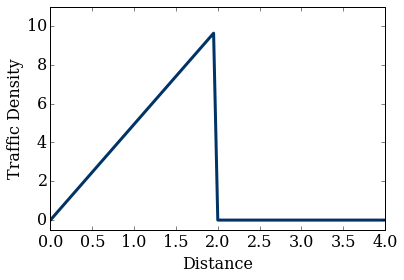

In [16]:
pyplot.plot(x, rho, color='#003366', ls='-',lw=3)
pyplot.ylabel('Traffic Density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

The density profile should move to the right once the light turns green.
Next a function will be created to calculate the traffic flux.

In [17]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho
    
    Parameters
    ----------
    u_max : float
        Maximum allowed velocity
    rho : array of floats
        Array with density of cars at every point x
    rho_max : float
        Maxmimum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

$$F = umax*rho (\frac{1-rho}{rhomax})$$

Discretized form of the traffic model is:
$$\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} + \frac{F_i^n - F_{i-1}^n}{\Delta x} = 0$$
Step in time using a for loop and operate on all spatial points simultaneously using array operations.
Need to call the computeF function at each time step as well

In [20]:
def ftbs(rho, nt, dt, dx, rho_max, u_max):
    """Computes the solution using forward in time, and backwards in space
    
    Parameters
    ----------
    rho : array of floats
        Density at current time-step
    nt : int
        Number of time-steps
    dt : float
        Time-step size
    dx : float
        Mesh spacing
    rho_max : float
        Maximum allowed car density
    u_max : float
        Speed limit
        
    Returns
    -------
    rho_n : array of floats
        Density after nt time-steps at every point x
    """
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    #copy the initial u array into each row of our new array
    rho_n[0,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:]-F[:-1])
        rho_n[t,0] = rho[0]
        rho = rho_n[t].copy()
        
    return rho_n

In [21]:
sigma = 1.
dt = sigma*dx

rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)

In [22]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation


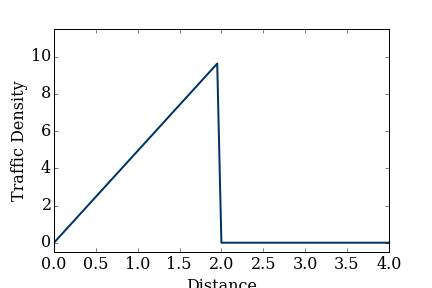
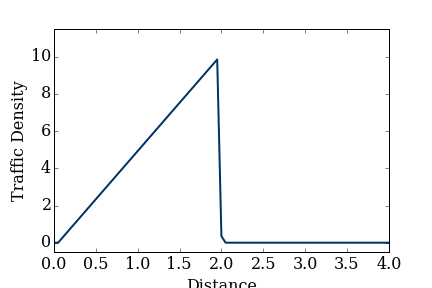
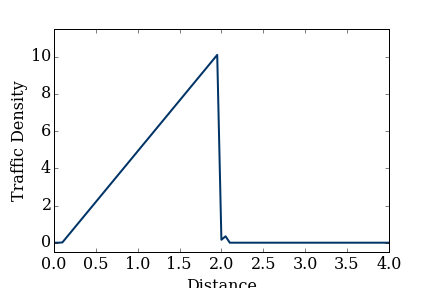
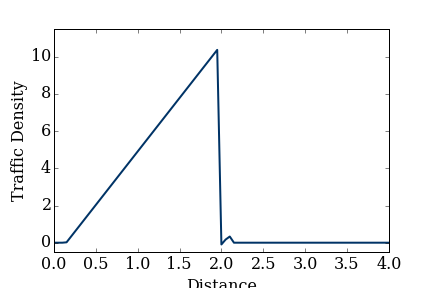
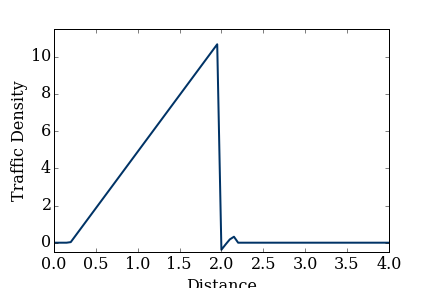
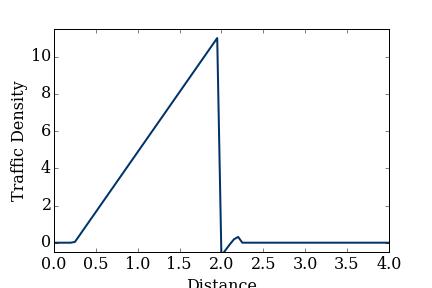
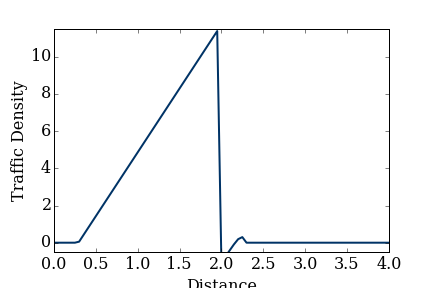
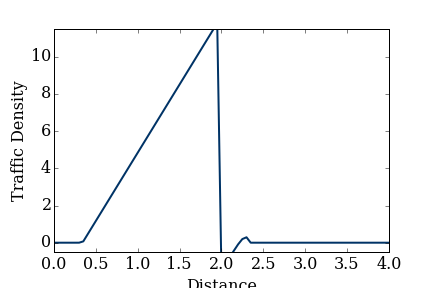
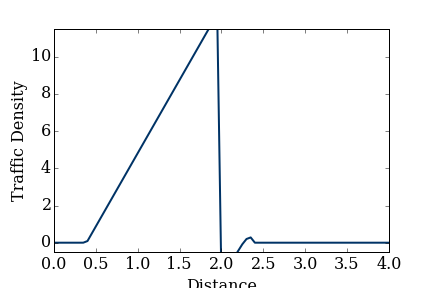
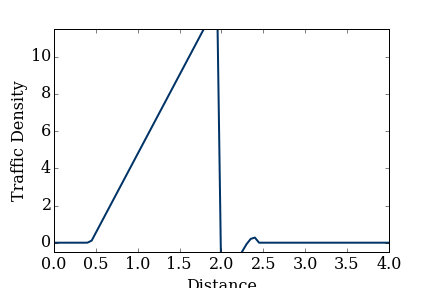
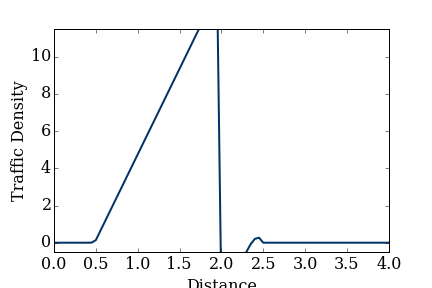
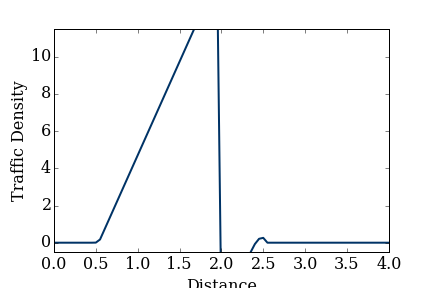
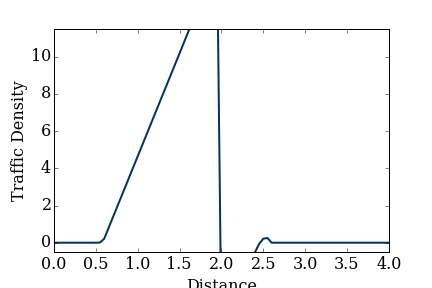
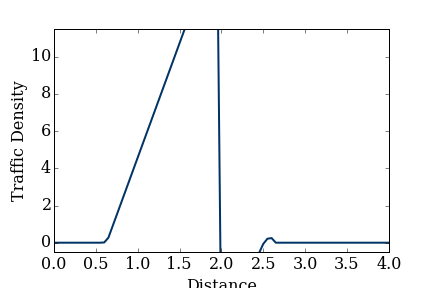
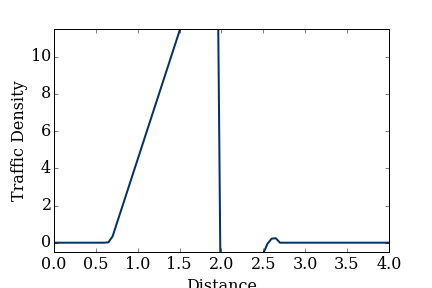
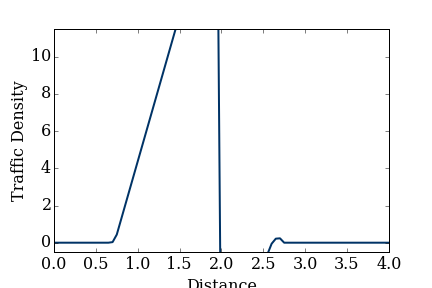
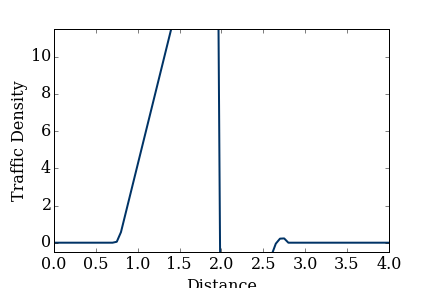
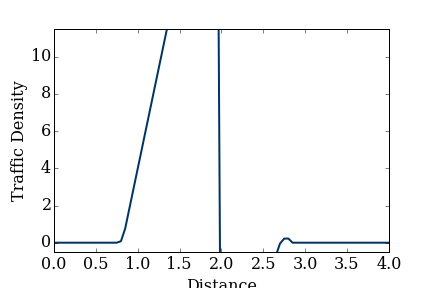
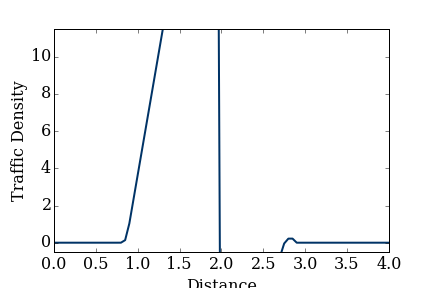
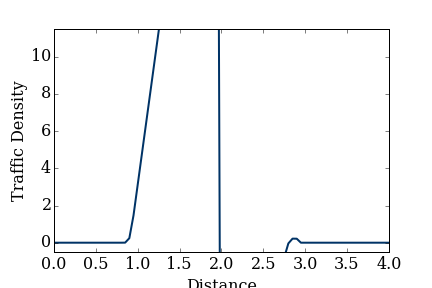
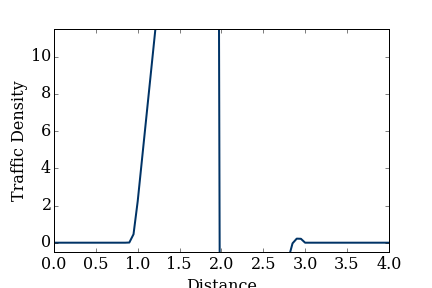
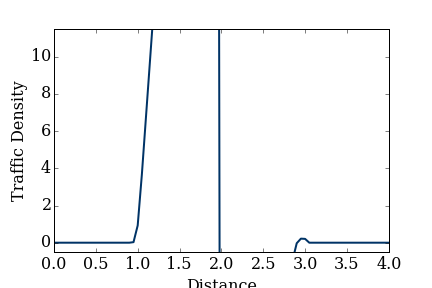
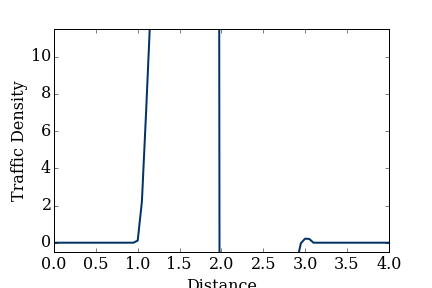
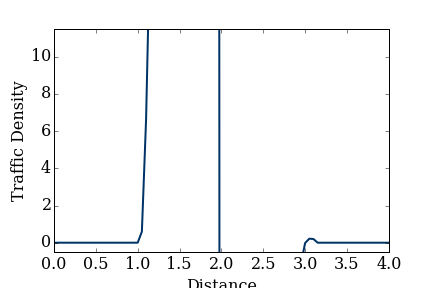
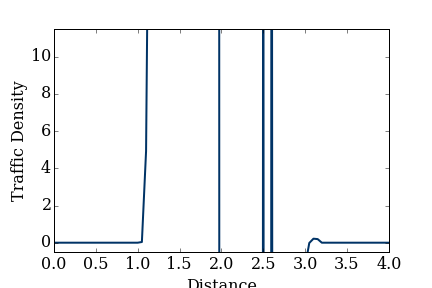
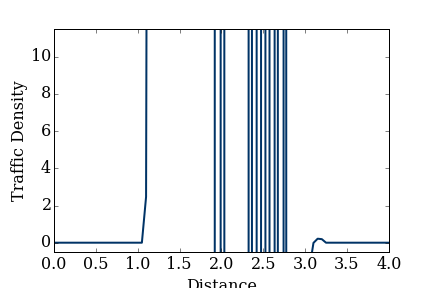
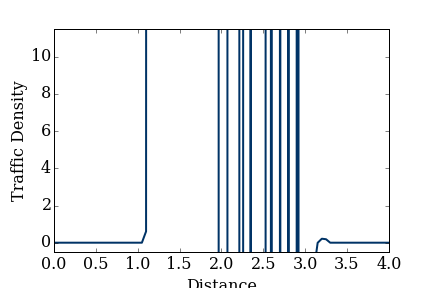
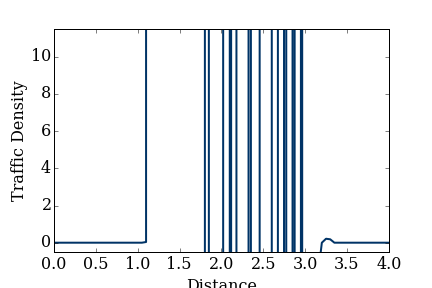
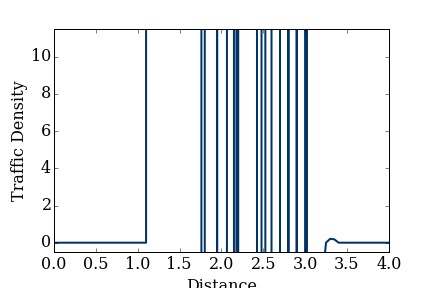
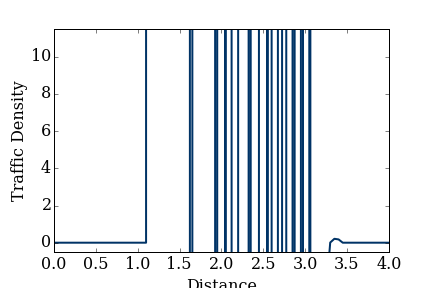

In [23]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-.5,11.5),xlabel=('Distance'),ylabel=('Traffic Density'));
line, = ax.plot([],[],color='#003366',lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig,animate,frames=rho_n,interval=50)
display_animation(anim,default_mode='once')

The solution blows up.  Need to look at the equation.
$$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0$$
Using the chain rule we get:
$$\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0$$
Looks like the nonlinear convection equation.

It is a wave equation where the wave speed is $$u_{wave} = \frac{\partial F}{\partial \rho}$$
$$u_{wave} = \frac{\partial F}{\partial \rho} = u_{max}(1 - 2\frac{\rho}{\rho _{max}})$$

The wave speed will change at $$\rho = \frac{\rho _{max}}{2}$$
The initial conditions will want to move right, but the section after will move left.

This means the scheme which is backward in space is *unstable* for negative values of the wave speed

To avoid having the wave travel in both directions we use an intial condition that does not produce a negative speed.

Use forward time/backward space scheme with initial conditions:
$$\rho(x,0) = 2.5x , 0 \leq x < 2$$
$$\rho(x,0) = 0 , 2 \leq x \leq 4$$
If all values of $\rho \leq \frac{\rho _{max}}{2}$
, then $\frac{\partial F}{\partial \rho}$ is positive everywhere

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



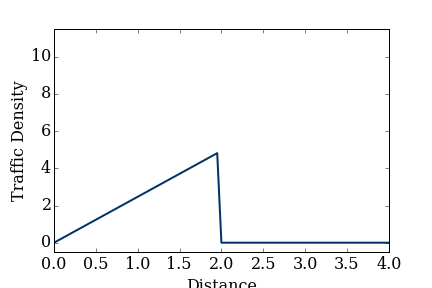
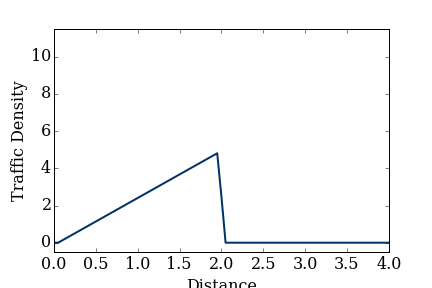
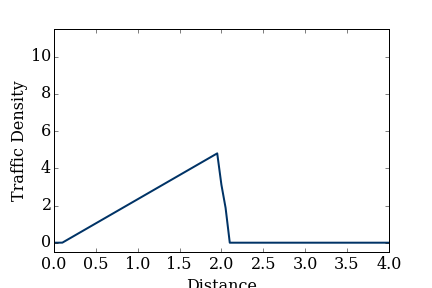
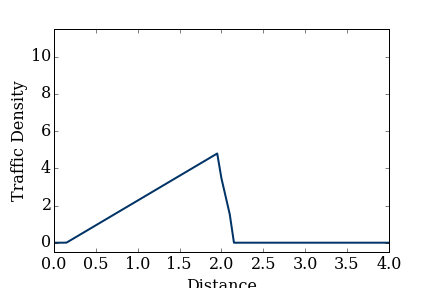
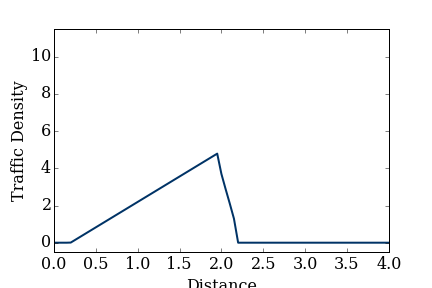
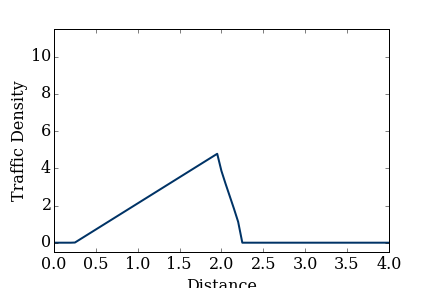
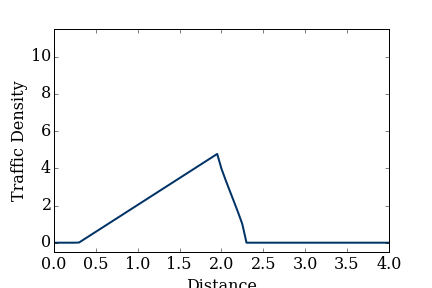
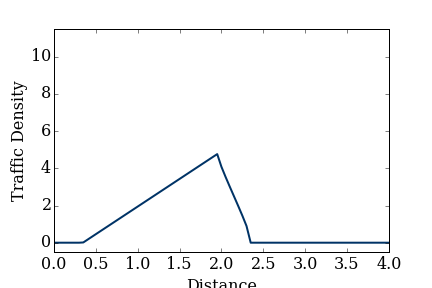
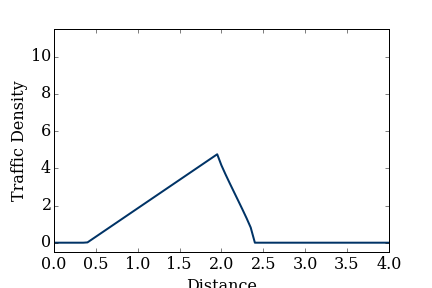
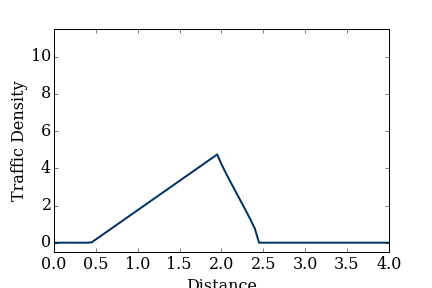
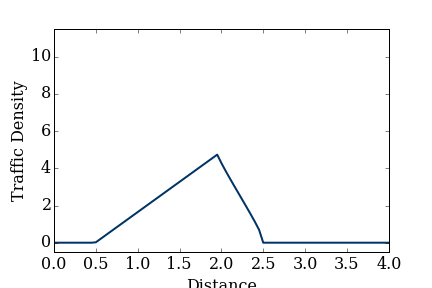
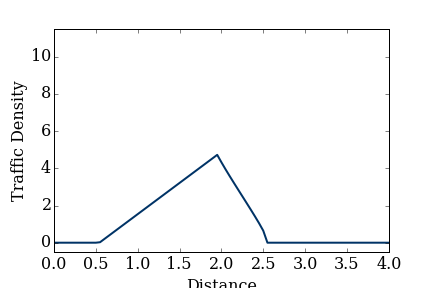
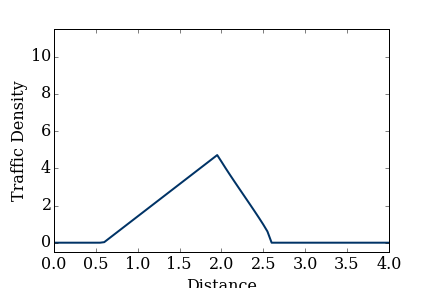
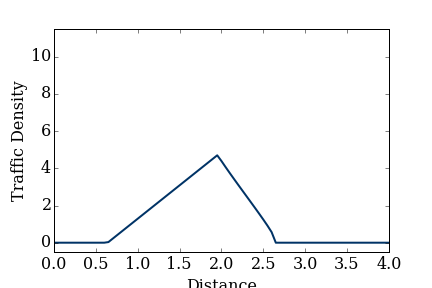
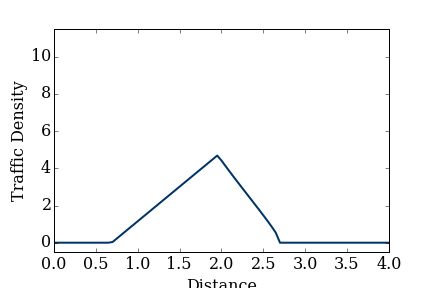
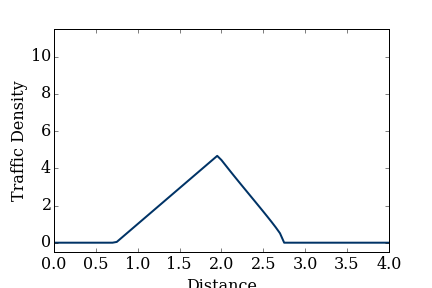
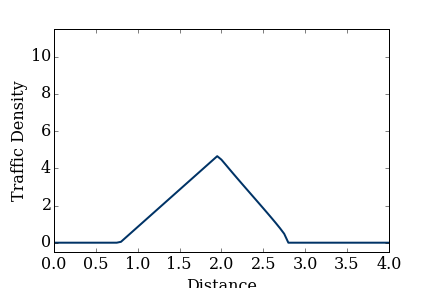
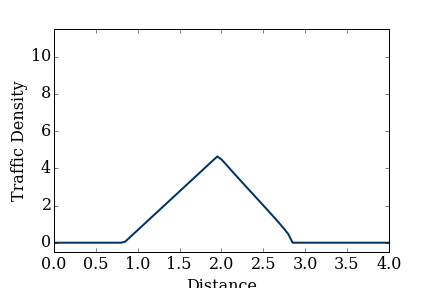
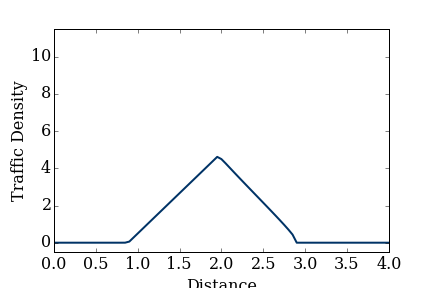
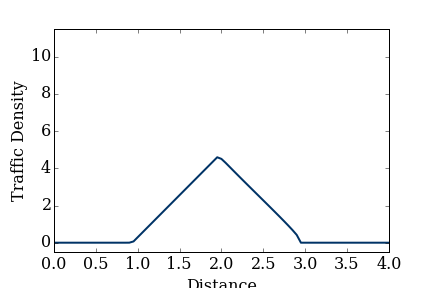
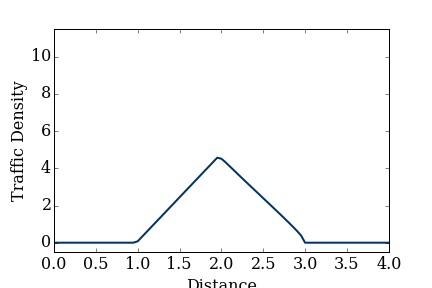
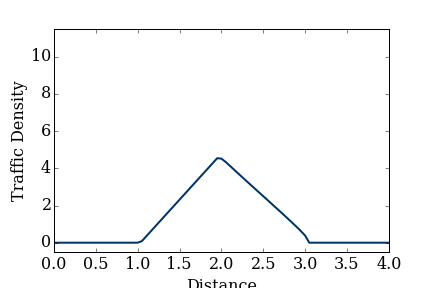
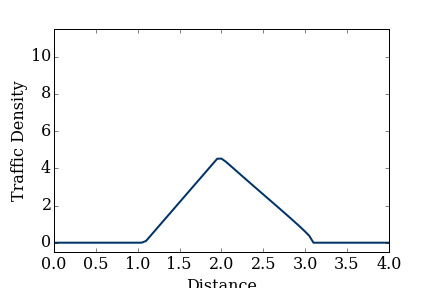
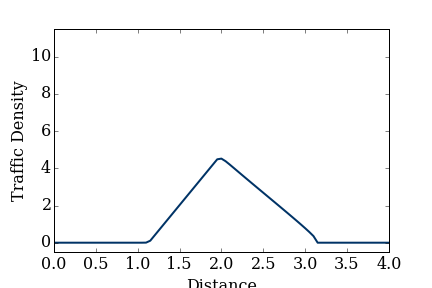
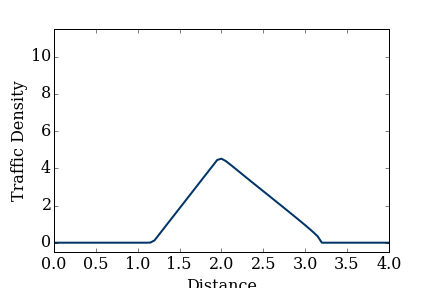
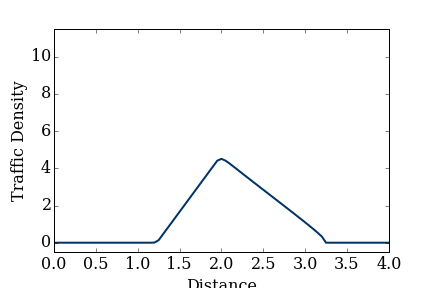
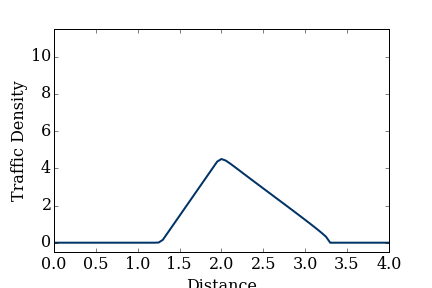
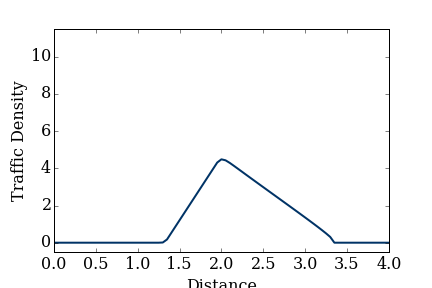
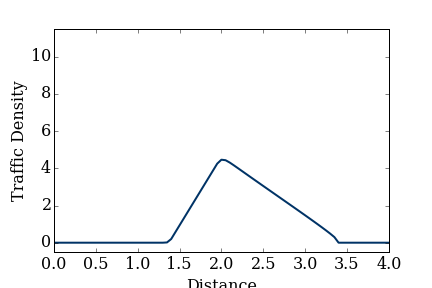
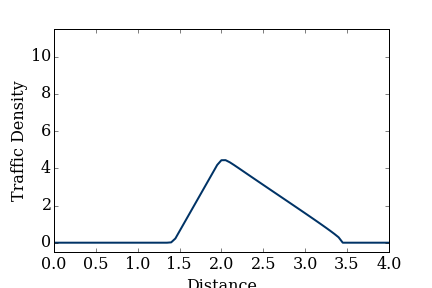
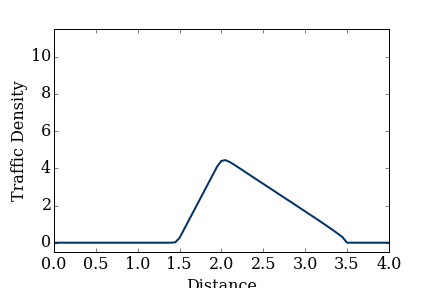
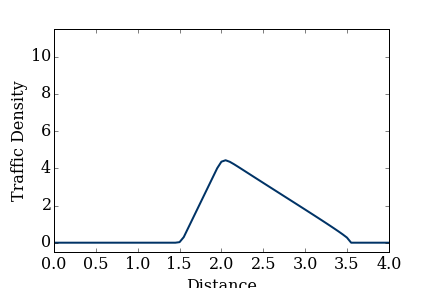
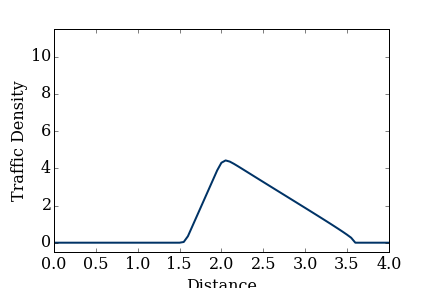
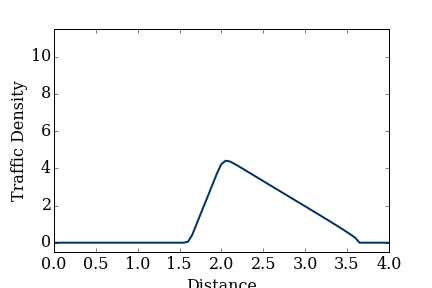
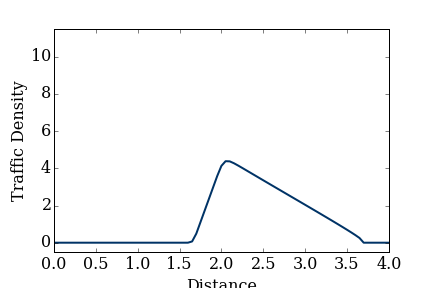
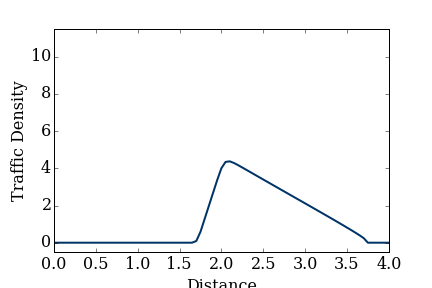
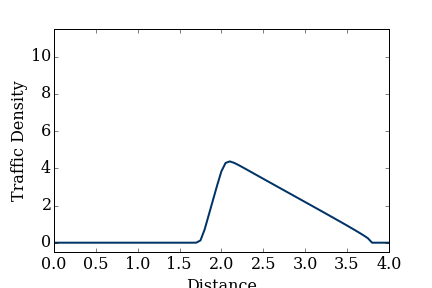
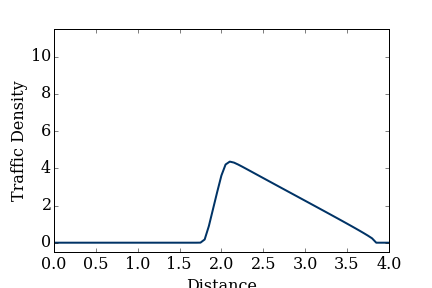
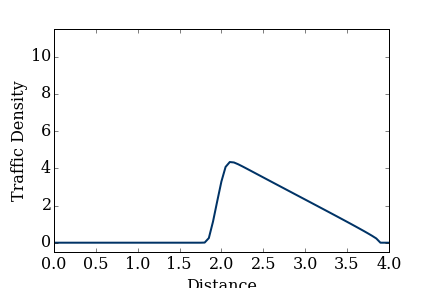
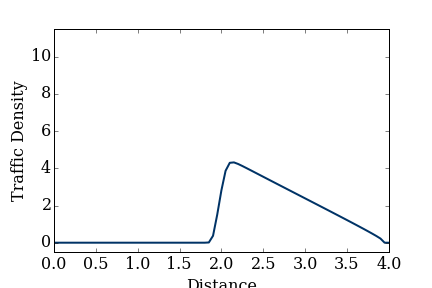

In [24]:
rho_light = 5.
nt = 40
rho = rho_green_light(nx, rho_light)
rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig,animate,frames=rho_n,interval=50)
display_animation(anim,default_mode='once')

CFL Condition: We've used it only with a constant wave speed
For a changing wave speed the CFL applies for every point in space and every point of time.
$$\sigma = max[|u_{wave}|\frac{\Delta t}{\Delta x}] < 1$$
Which leads to $$\sigma = max[u_{max}|1-\frac{\rho}{\rho _{max}}|\frac{\Delta t}{\Delta x}] < 1$$
The closer $\rho$ is to zero, the more likely it is to be unstable

Earlier our initial conditions we used gave us a CFL = 1, when $\rho$ = 0.  Lets try changing $u_{max}$ = 1.1

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



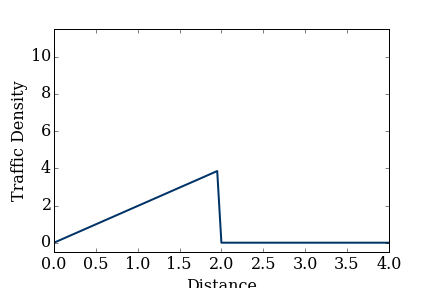
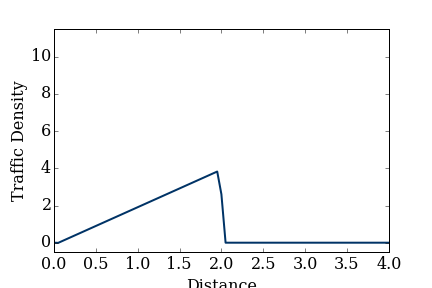
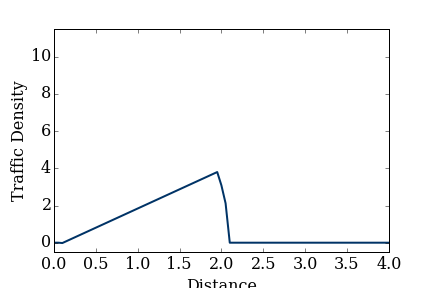
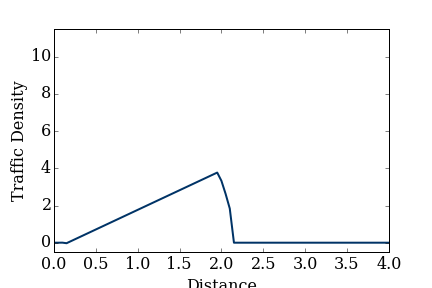
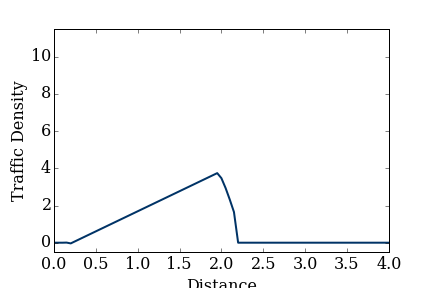
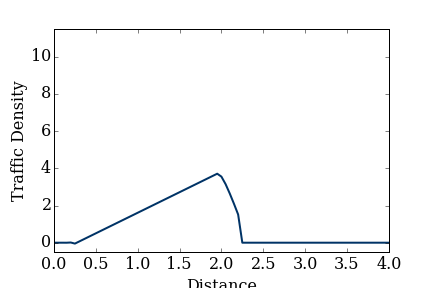
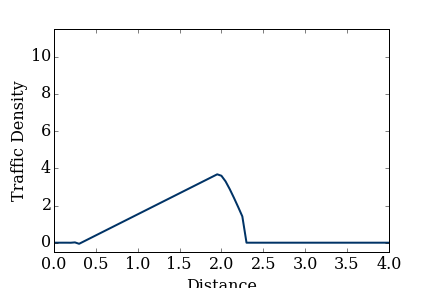
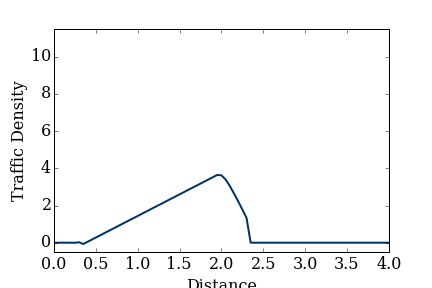
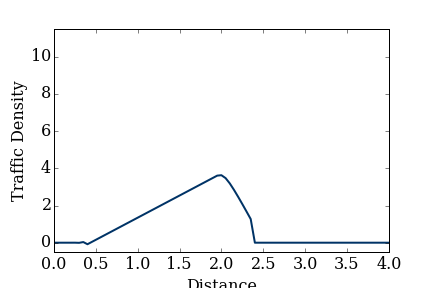
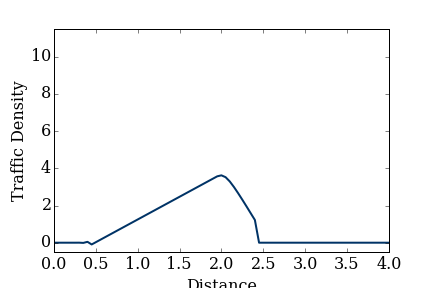
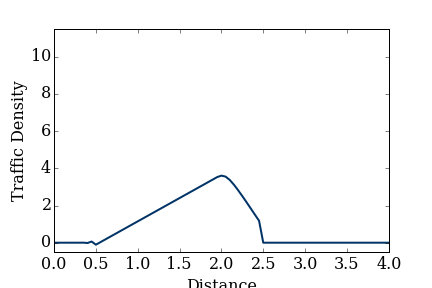
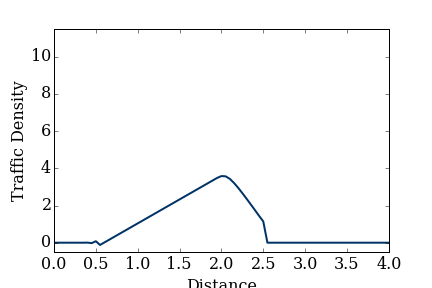
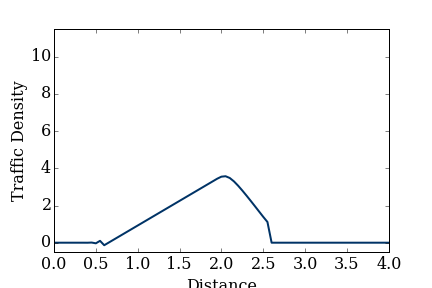
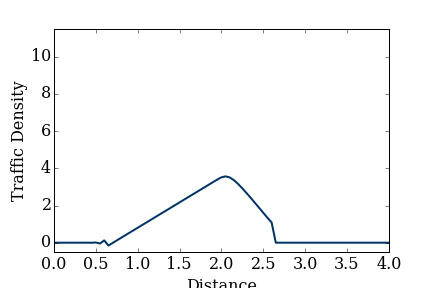
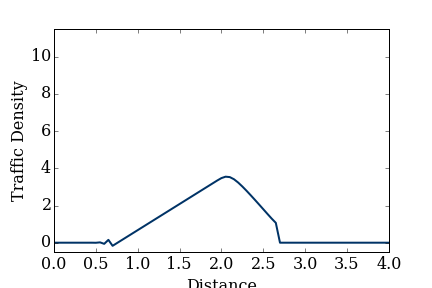
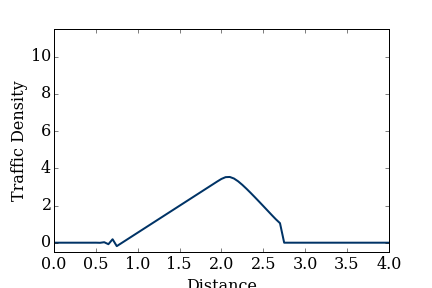
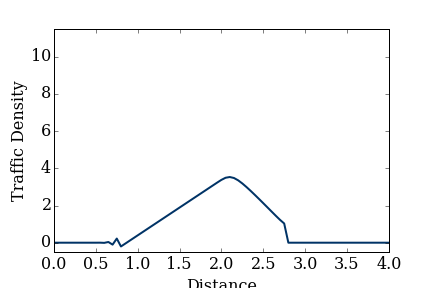
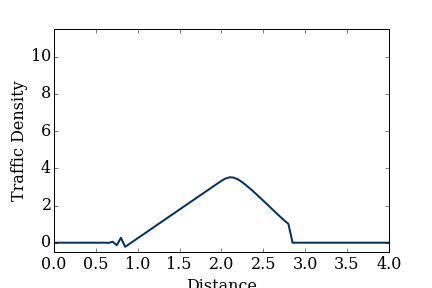
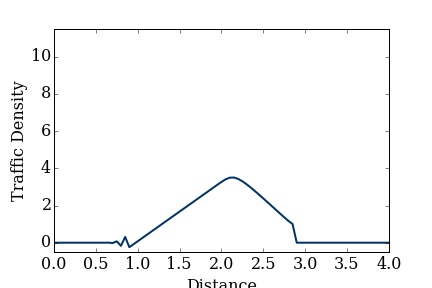
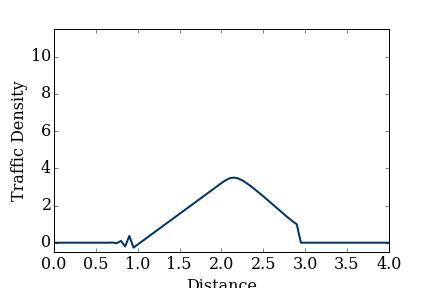
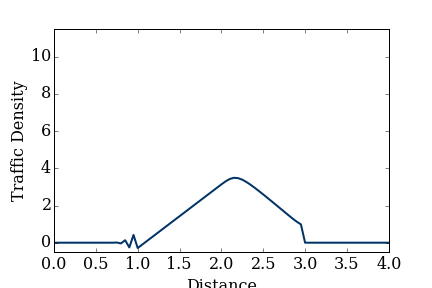
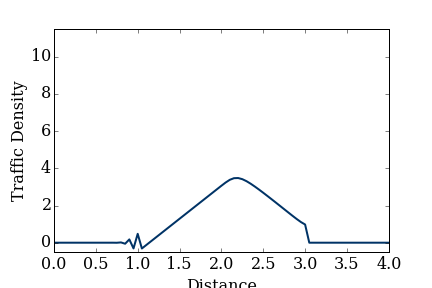
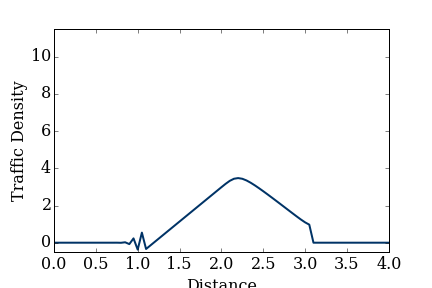
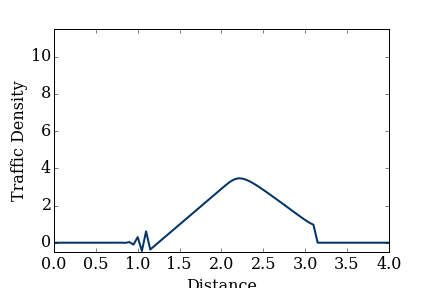
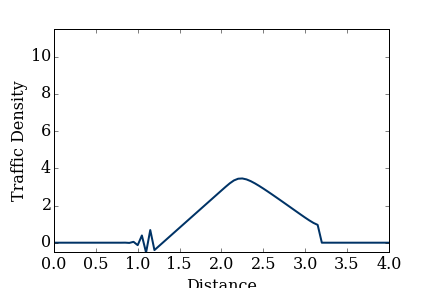
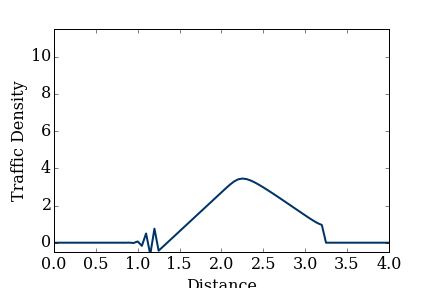
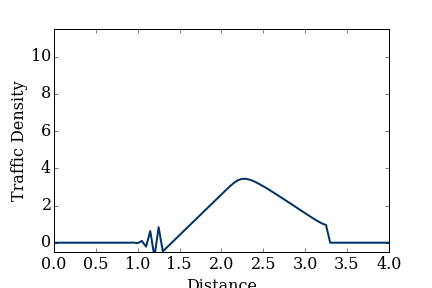
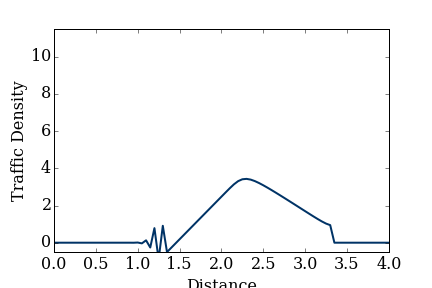
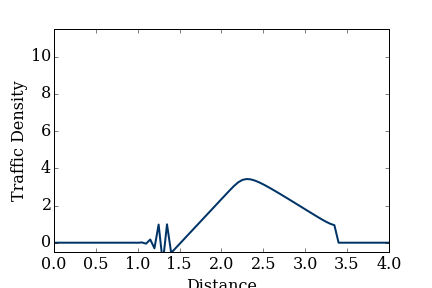
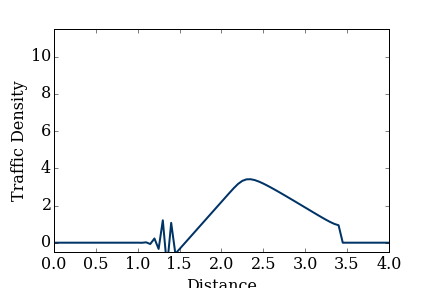
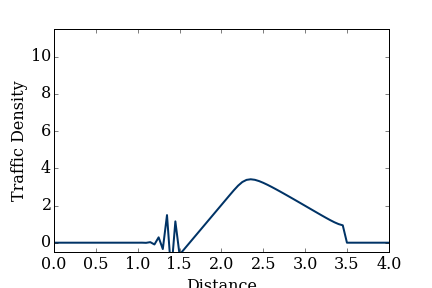
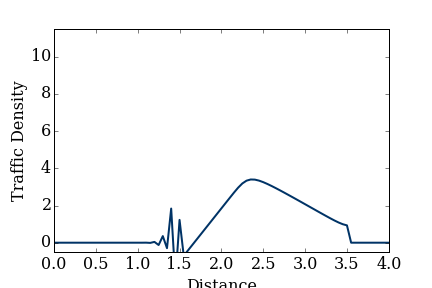
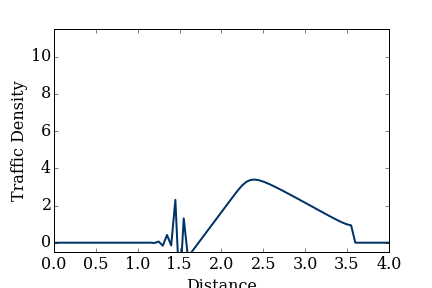
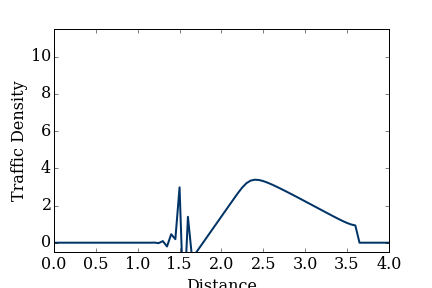
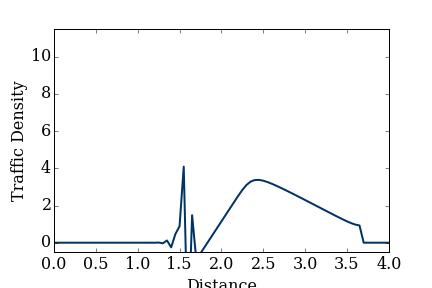
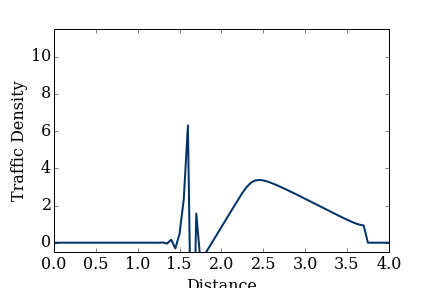
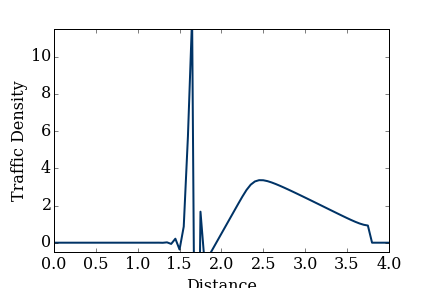
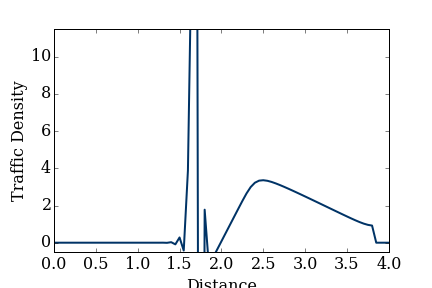
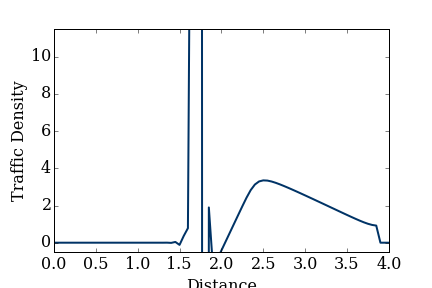
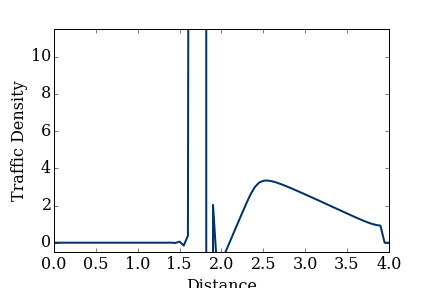

In [25]:
rho_light = 4.
u_max = 1.1
nt = 40
rho = rho_green_light(nx, rho_light)
rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')